In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import string
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Add nltk_data path
nltk.data.path.append('./nltk_data/')

# Download nltk data and save to ./nltk_data/ folder
nltk.download('punkt', download_dir='./nltk_data/')
nltk.download('stopwords', download_dir='./nltk_data/')
nltk.download('wordnet', download_dir='./nltk_data/')
sns.set_style("whitegrid")

[nltk_data] Downloading package punkt to ./nltk_data/...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to ./nltk_data/...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to ./nltk_data/...


In [2]:
# read the dataset
train = pd.read_csv('./archive/train.csv')
test = pd.read_csv('./archive/test.csv')
test_labels = pd.read_csv('./archive/test_labels.csv')
sample_submission = pd.read_csv('./archive/sample_submission.csv')
train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [3]:
test

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [4]:
test_labels

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,-1,-1,-1,-1,-1,-1


In [5]:
sample_submission

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.5,0.5,0.5,0.5,0.5,0.5
153160,fffd7a9a6eb32c16,0.5,0.5,0.5,0.5,0.5,0.5
153161,fffda9e8d6fafa9e,0.5,0.5,0.5,0.5,0.5,0.5
153162,fffe8f1340a79fc2,0.5,0.5,0.5,0.5,0.5,0.5


In [6]:
train.shape, test.shape, test_labels.shape, sample_submission.shape

((159571, 8), (153164, 2), (153164, 7), (153164, 7))

In [7]:
# check the missing values
missing_values = train.isnull().sum()
missing_values

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

It is clear that there are no missing values in the dataset.

In [8]:
# count the number of each label
labels = train.columns[2:]
label_counts = train[labels].sum().sort_values(ascending=False)
label_counts

toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64

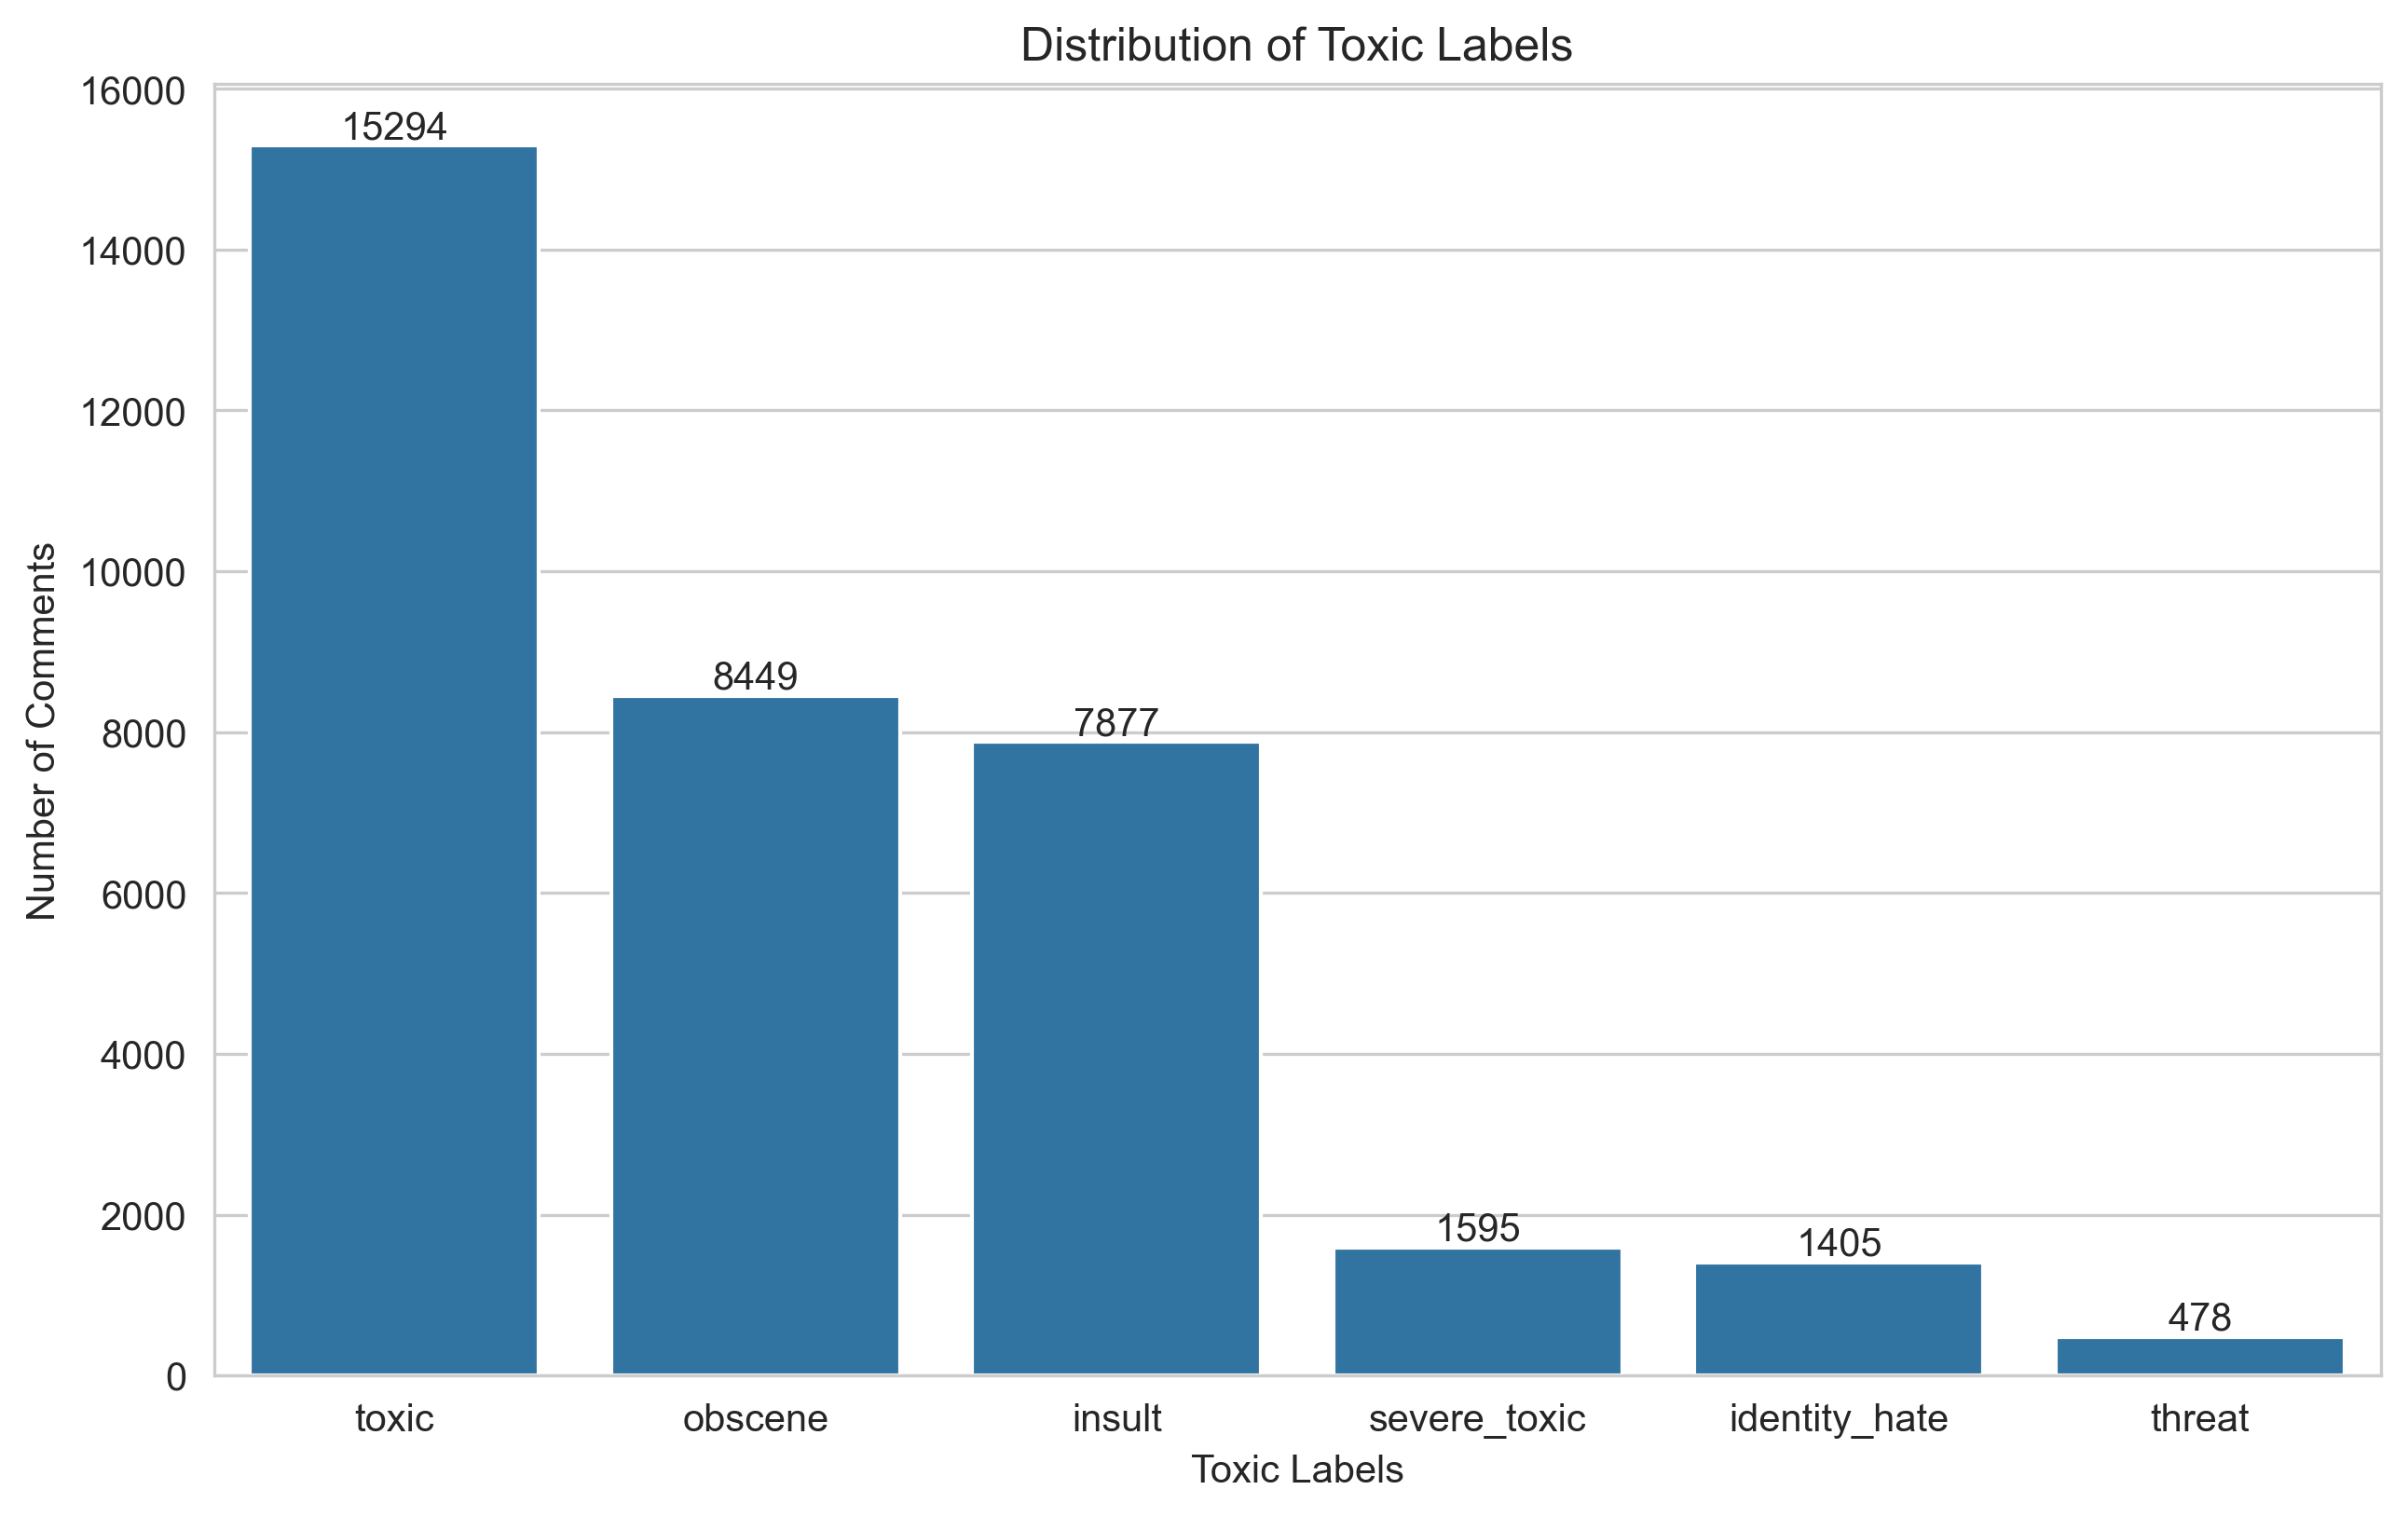

In [9]:
# plot the distribution of each label
plt.figure(figsize=(10,6), dpi=300)
sns.barplot(x=label_counts.index, y=label_counts.values)
for index, value in enumerate(label_counts):
    plt.text(index, value, str(value), ha='center', va='bottom')
plt.title('Distribution of Toxic Labels')
plt.xlabel('Toxic Labels')
plt.ylabel('Number of Comments')
plt.show()

We can observe that the toxic labels are highly imbalanced. In toxic comments, the comments with label "toxic" are the most common, followed by "obscene", "insult". The number of comments with label "severe_toxic", "identity_hate" and "threat" are rare. It means that we may encounter the problem of overfitting when training the model.

In [10]:
# count the number of comments with multiple labels
row_sum = train.iloc[:, 2:].sum(axis=1)
multi_label_counts = row_sum.value_counts()
multi_label_counts

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: count, dtype: int64

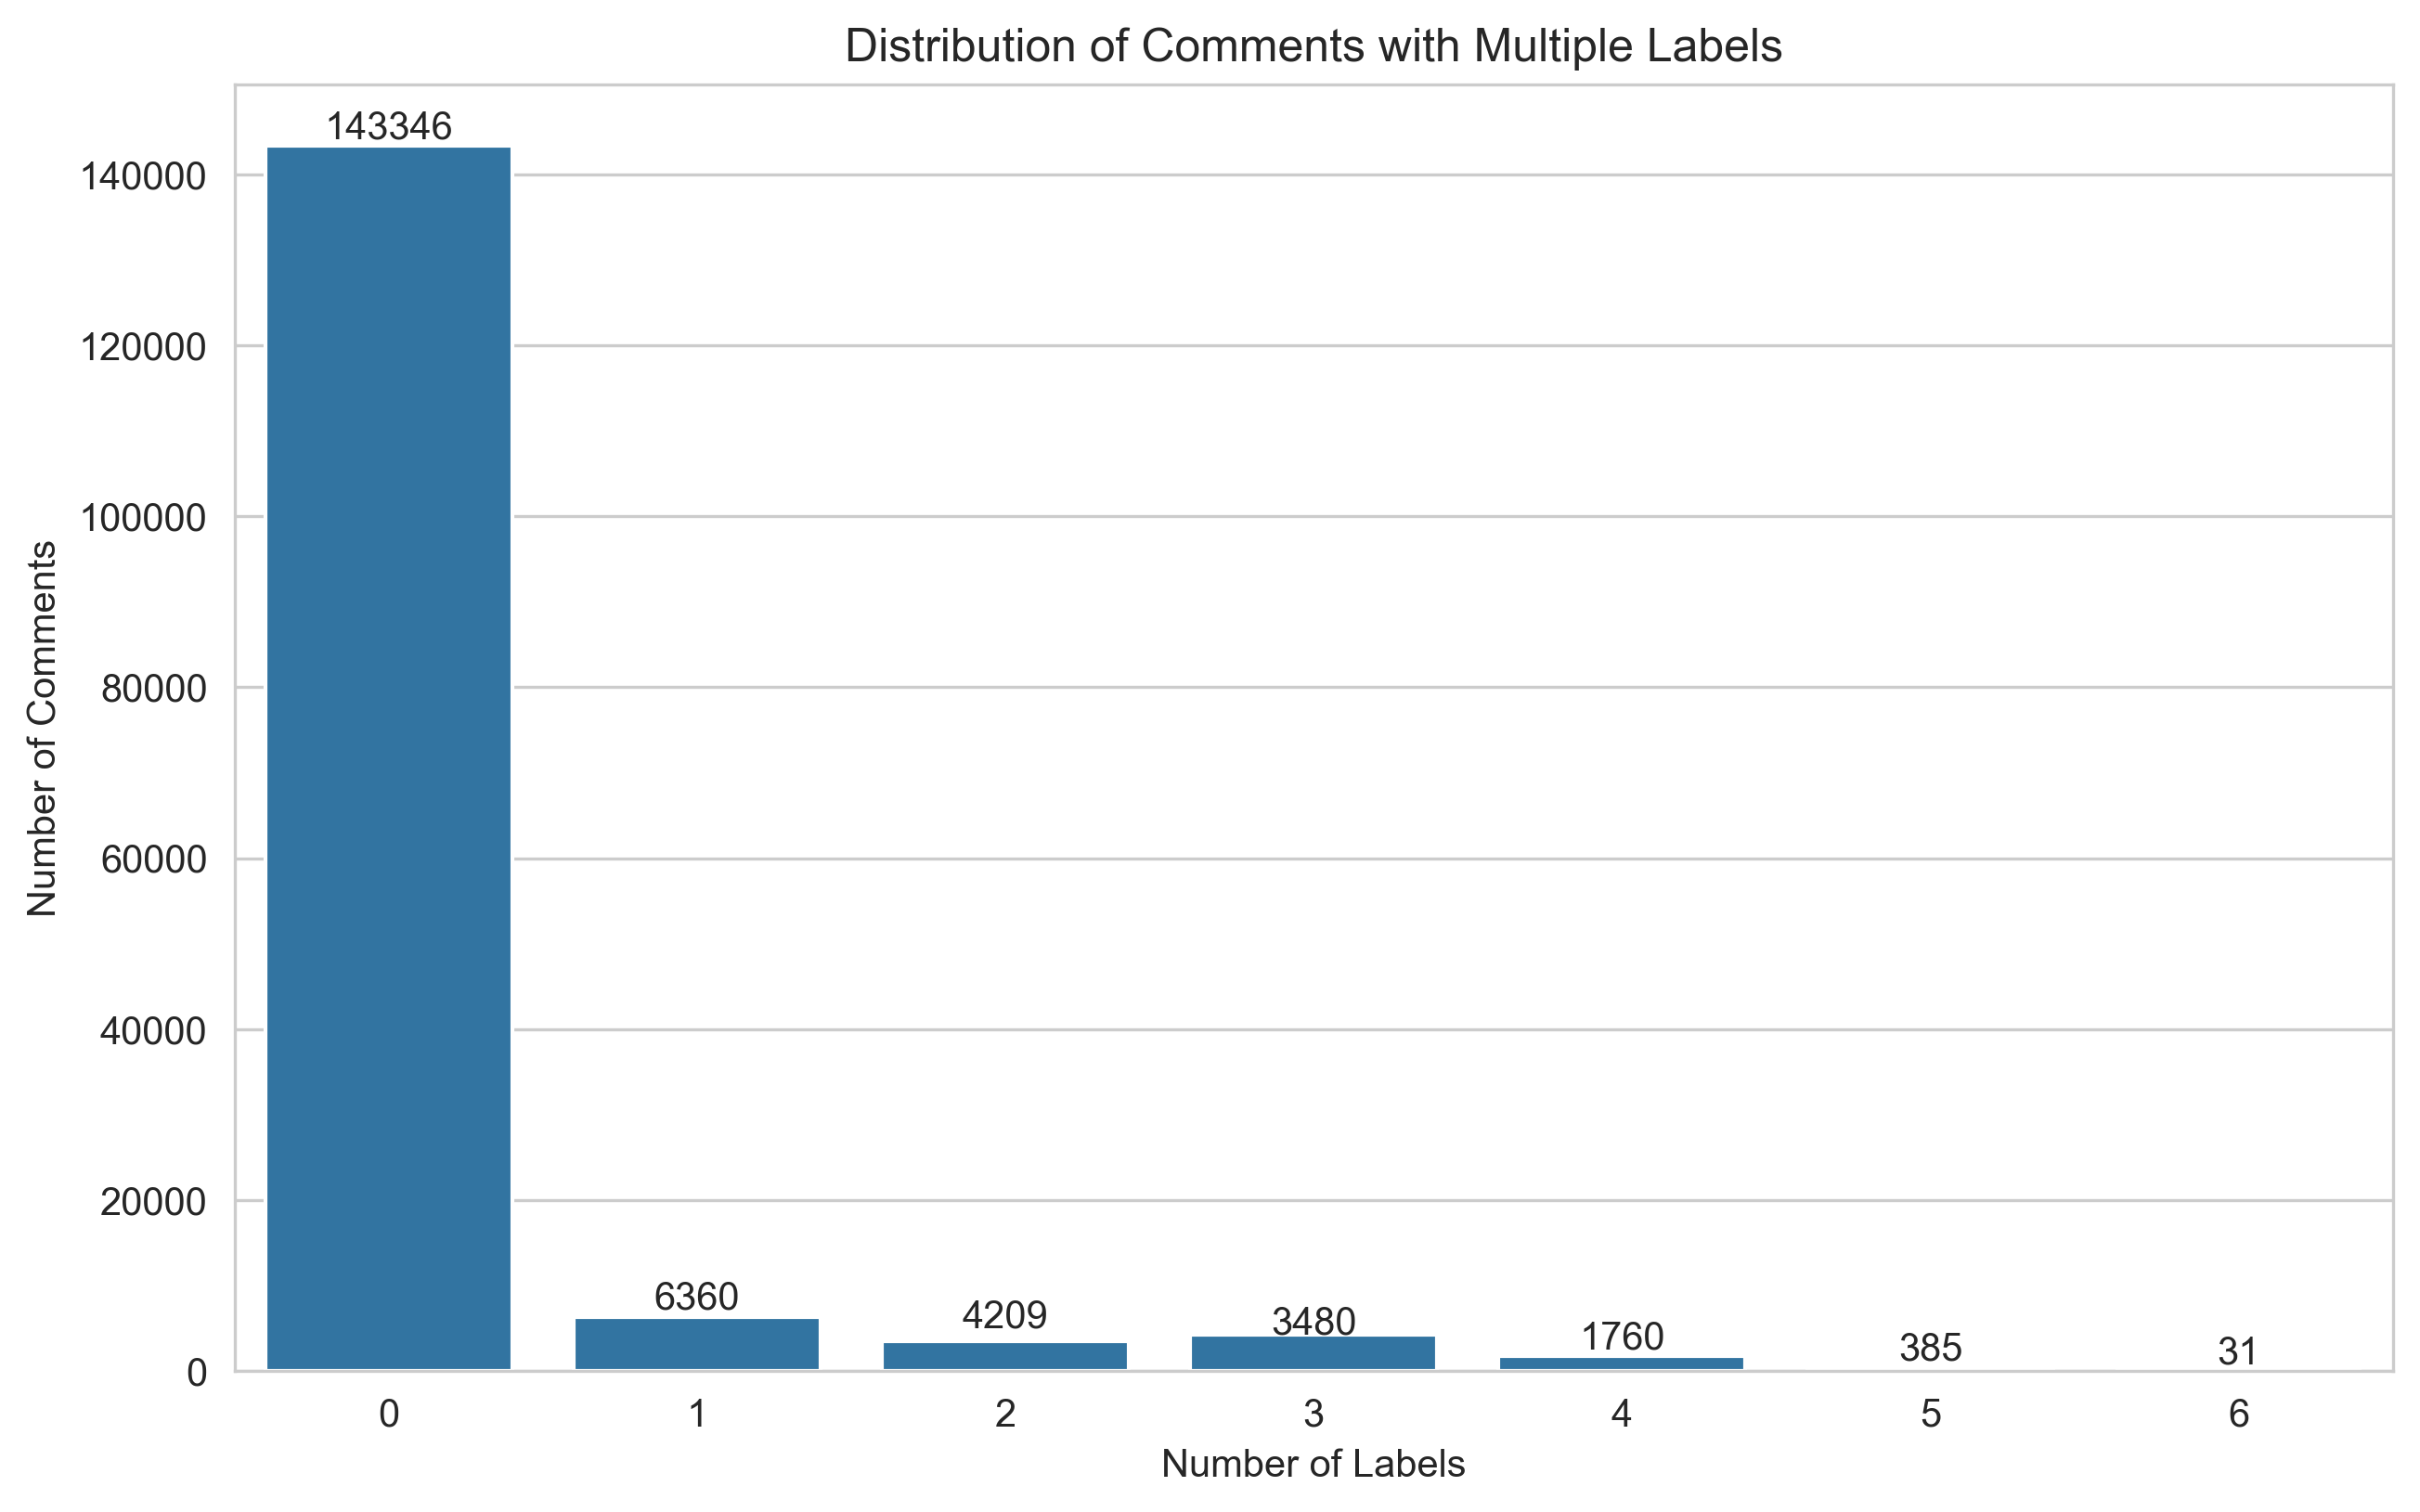

In [11]:
# plot the distribution of comments with multiple labels
plt.figure(figsize=(10,6), dpi=300)
sns.barplot(x=multi_label_counts.index, y=multi_label_counts.values)
for index, value in enumerate(multi_label_counts):
    plt.text(index, value, str(value), ha='center', va='bottom')
plt.title('Distribution of Comments with Multiple Labels')
plt.xlabel('Number of Labels')
plt.ylabel('Number of Comments')
plt.show()

The diagram shows that most comments in train dataset are not toxic. In toxic comments, several comments have multiple labels. Some of them even have all six labels. We need to build a multi-label classification model to solve this problem.

In [12]:
# calculate the correlation matrix
corr = train.iloc[:,2:].corr()
corr

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009
severe_toxic,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600
obscene,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867
threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128
insult,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736
identity_hate,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000


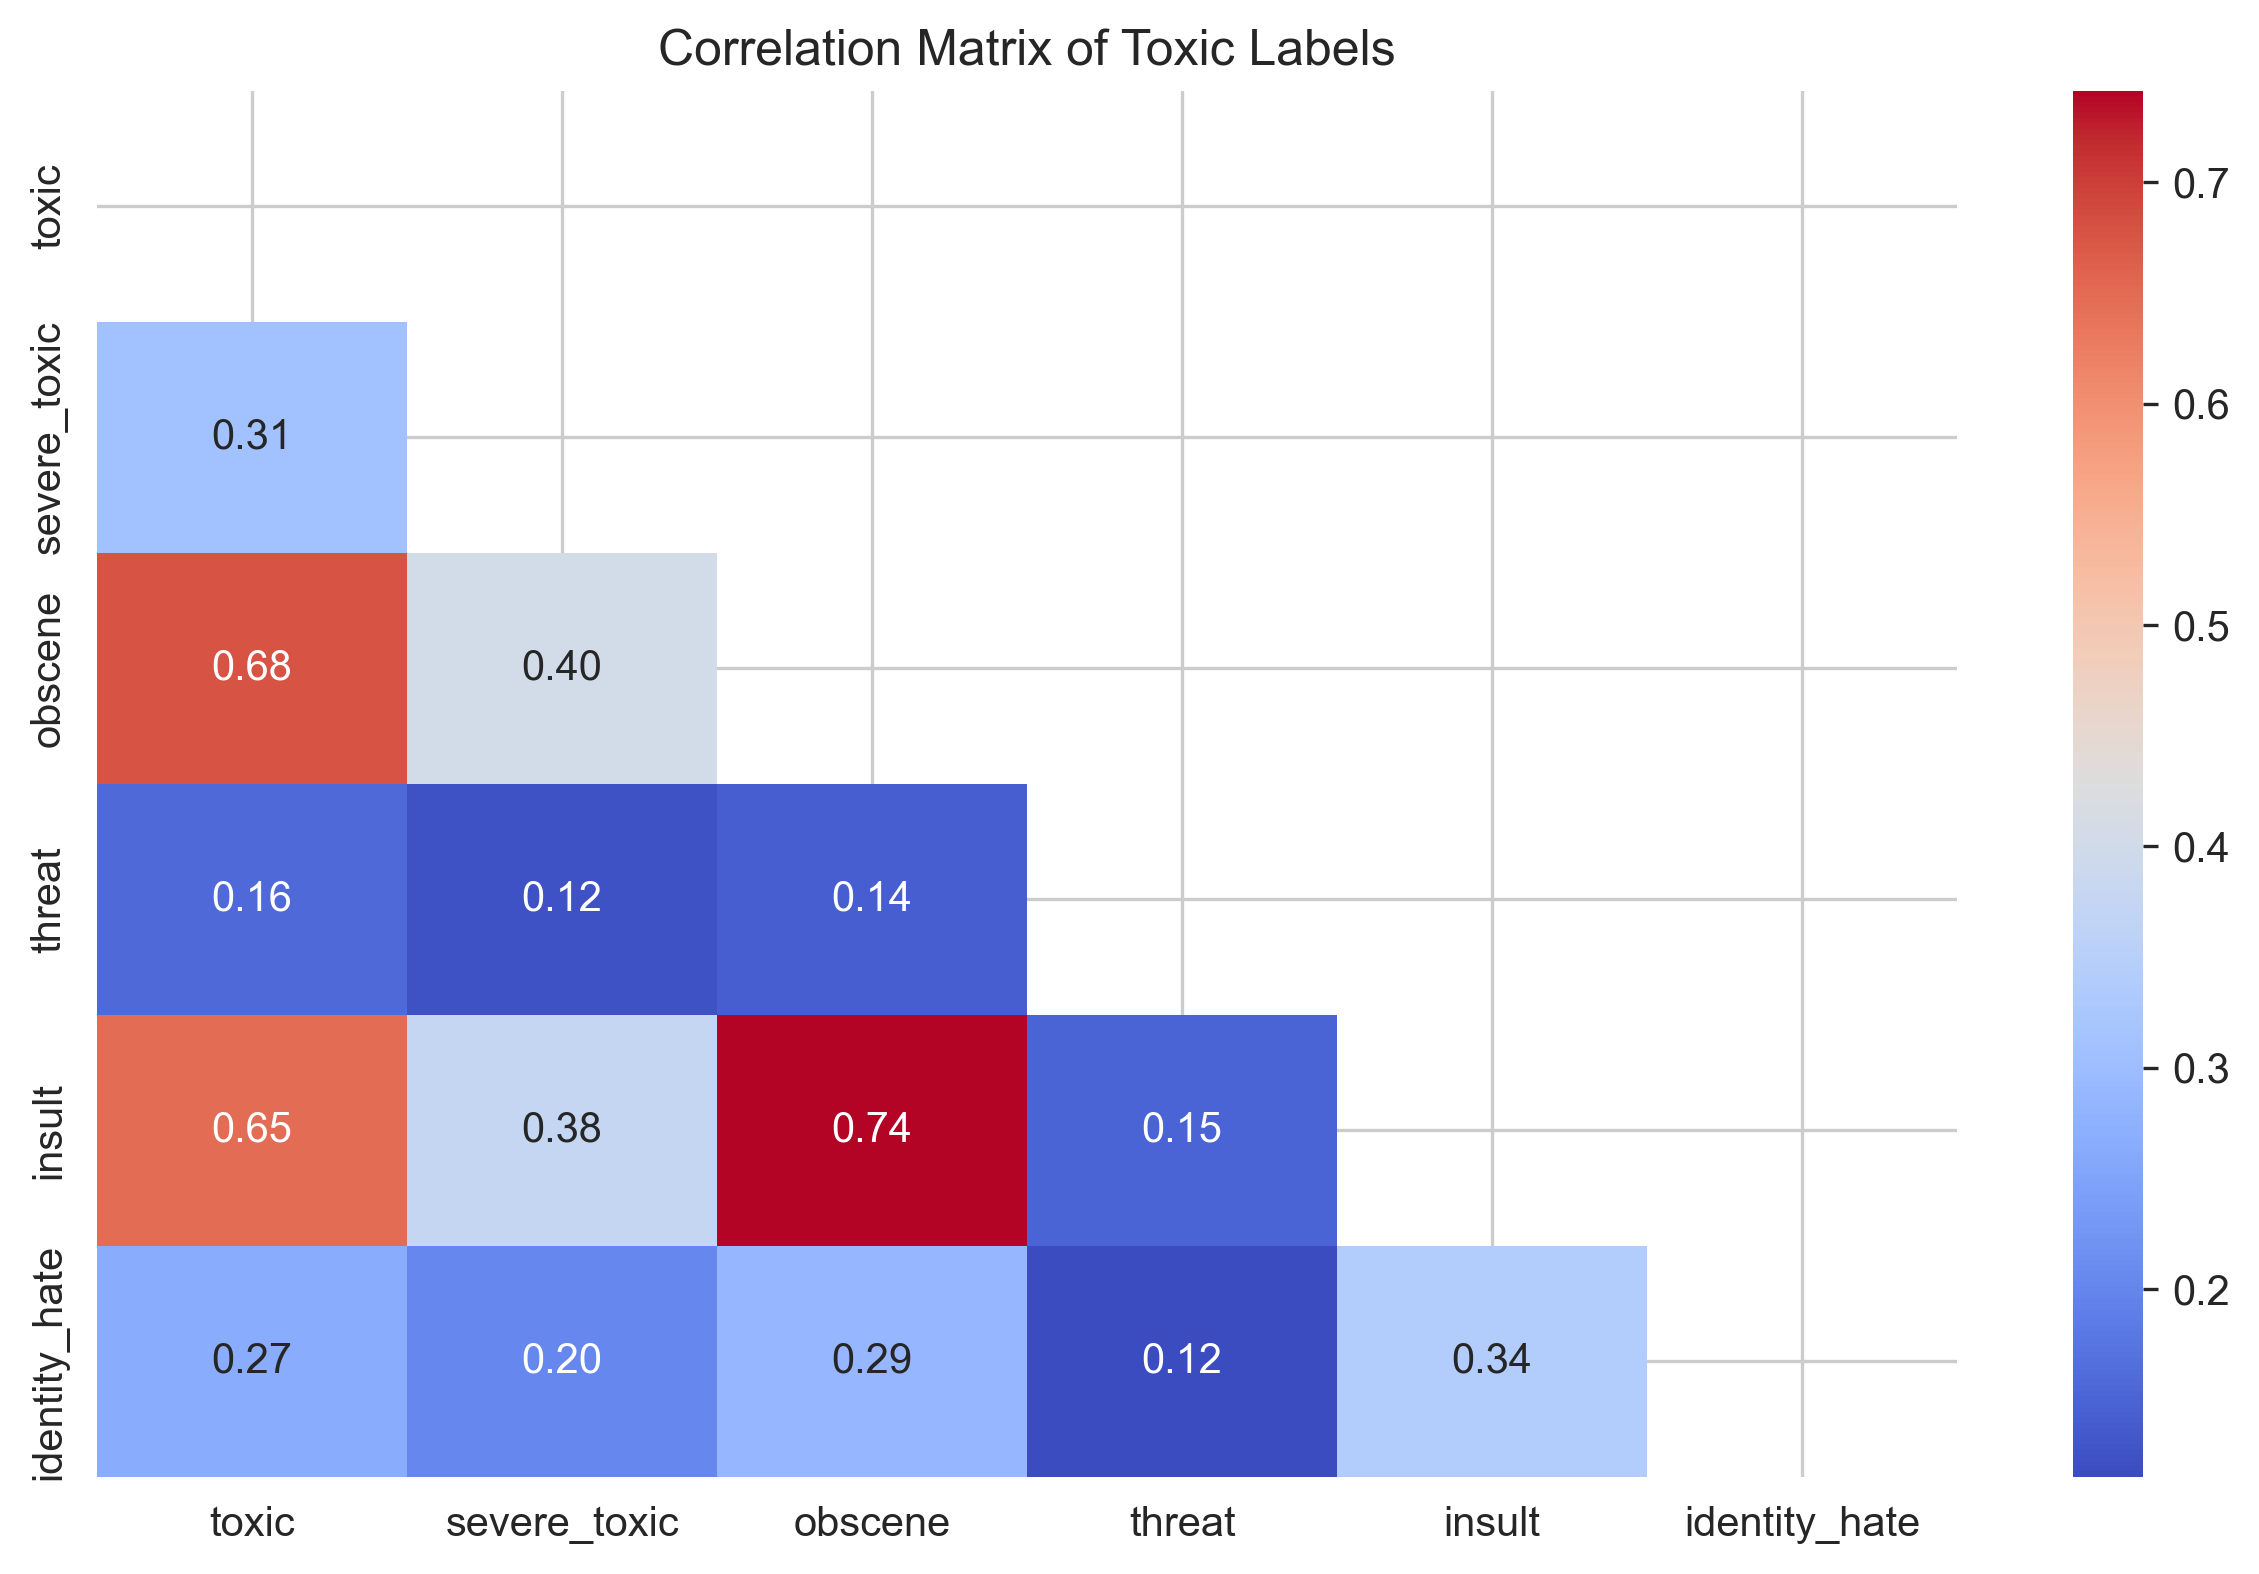

In [13]:
# plot the correlation matrix as a heatmap
plt.figure(figsize=(10,6), dpi=300)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Matrix of Toxic Labels')
plt.show()

The correlation matrix shows the correlation between the different labels of toxic comments. As we can see from the heatmap, there is a strong correlation between some labels, such as "toxic" and "obscene", "toxic" and "insult", "obscene" and "insult". It means that the comments with these labels are highly related. This is helpful in building a multi-label classification model.

In [14]:
# calculate the length of each comment
train['comment_length'] = train['comment_text'].apply(len)
train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_length
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67
...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,295
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,99
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,81
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,116


In [15]:
train['comment_length'].describe()

count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_length, dtype: float64

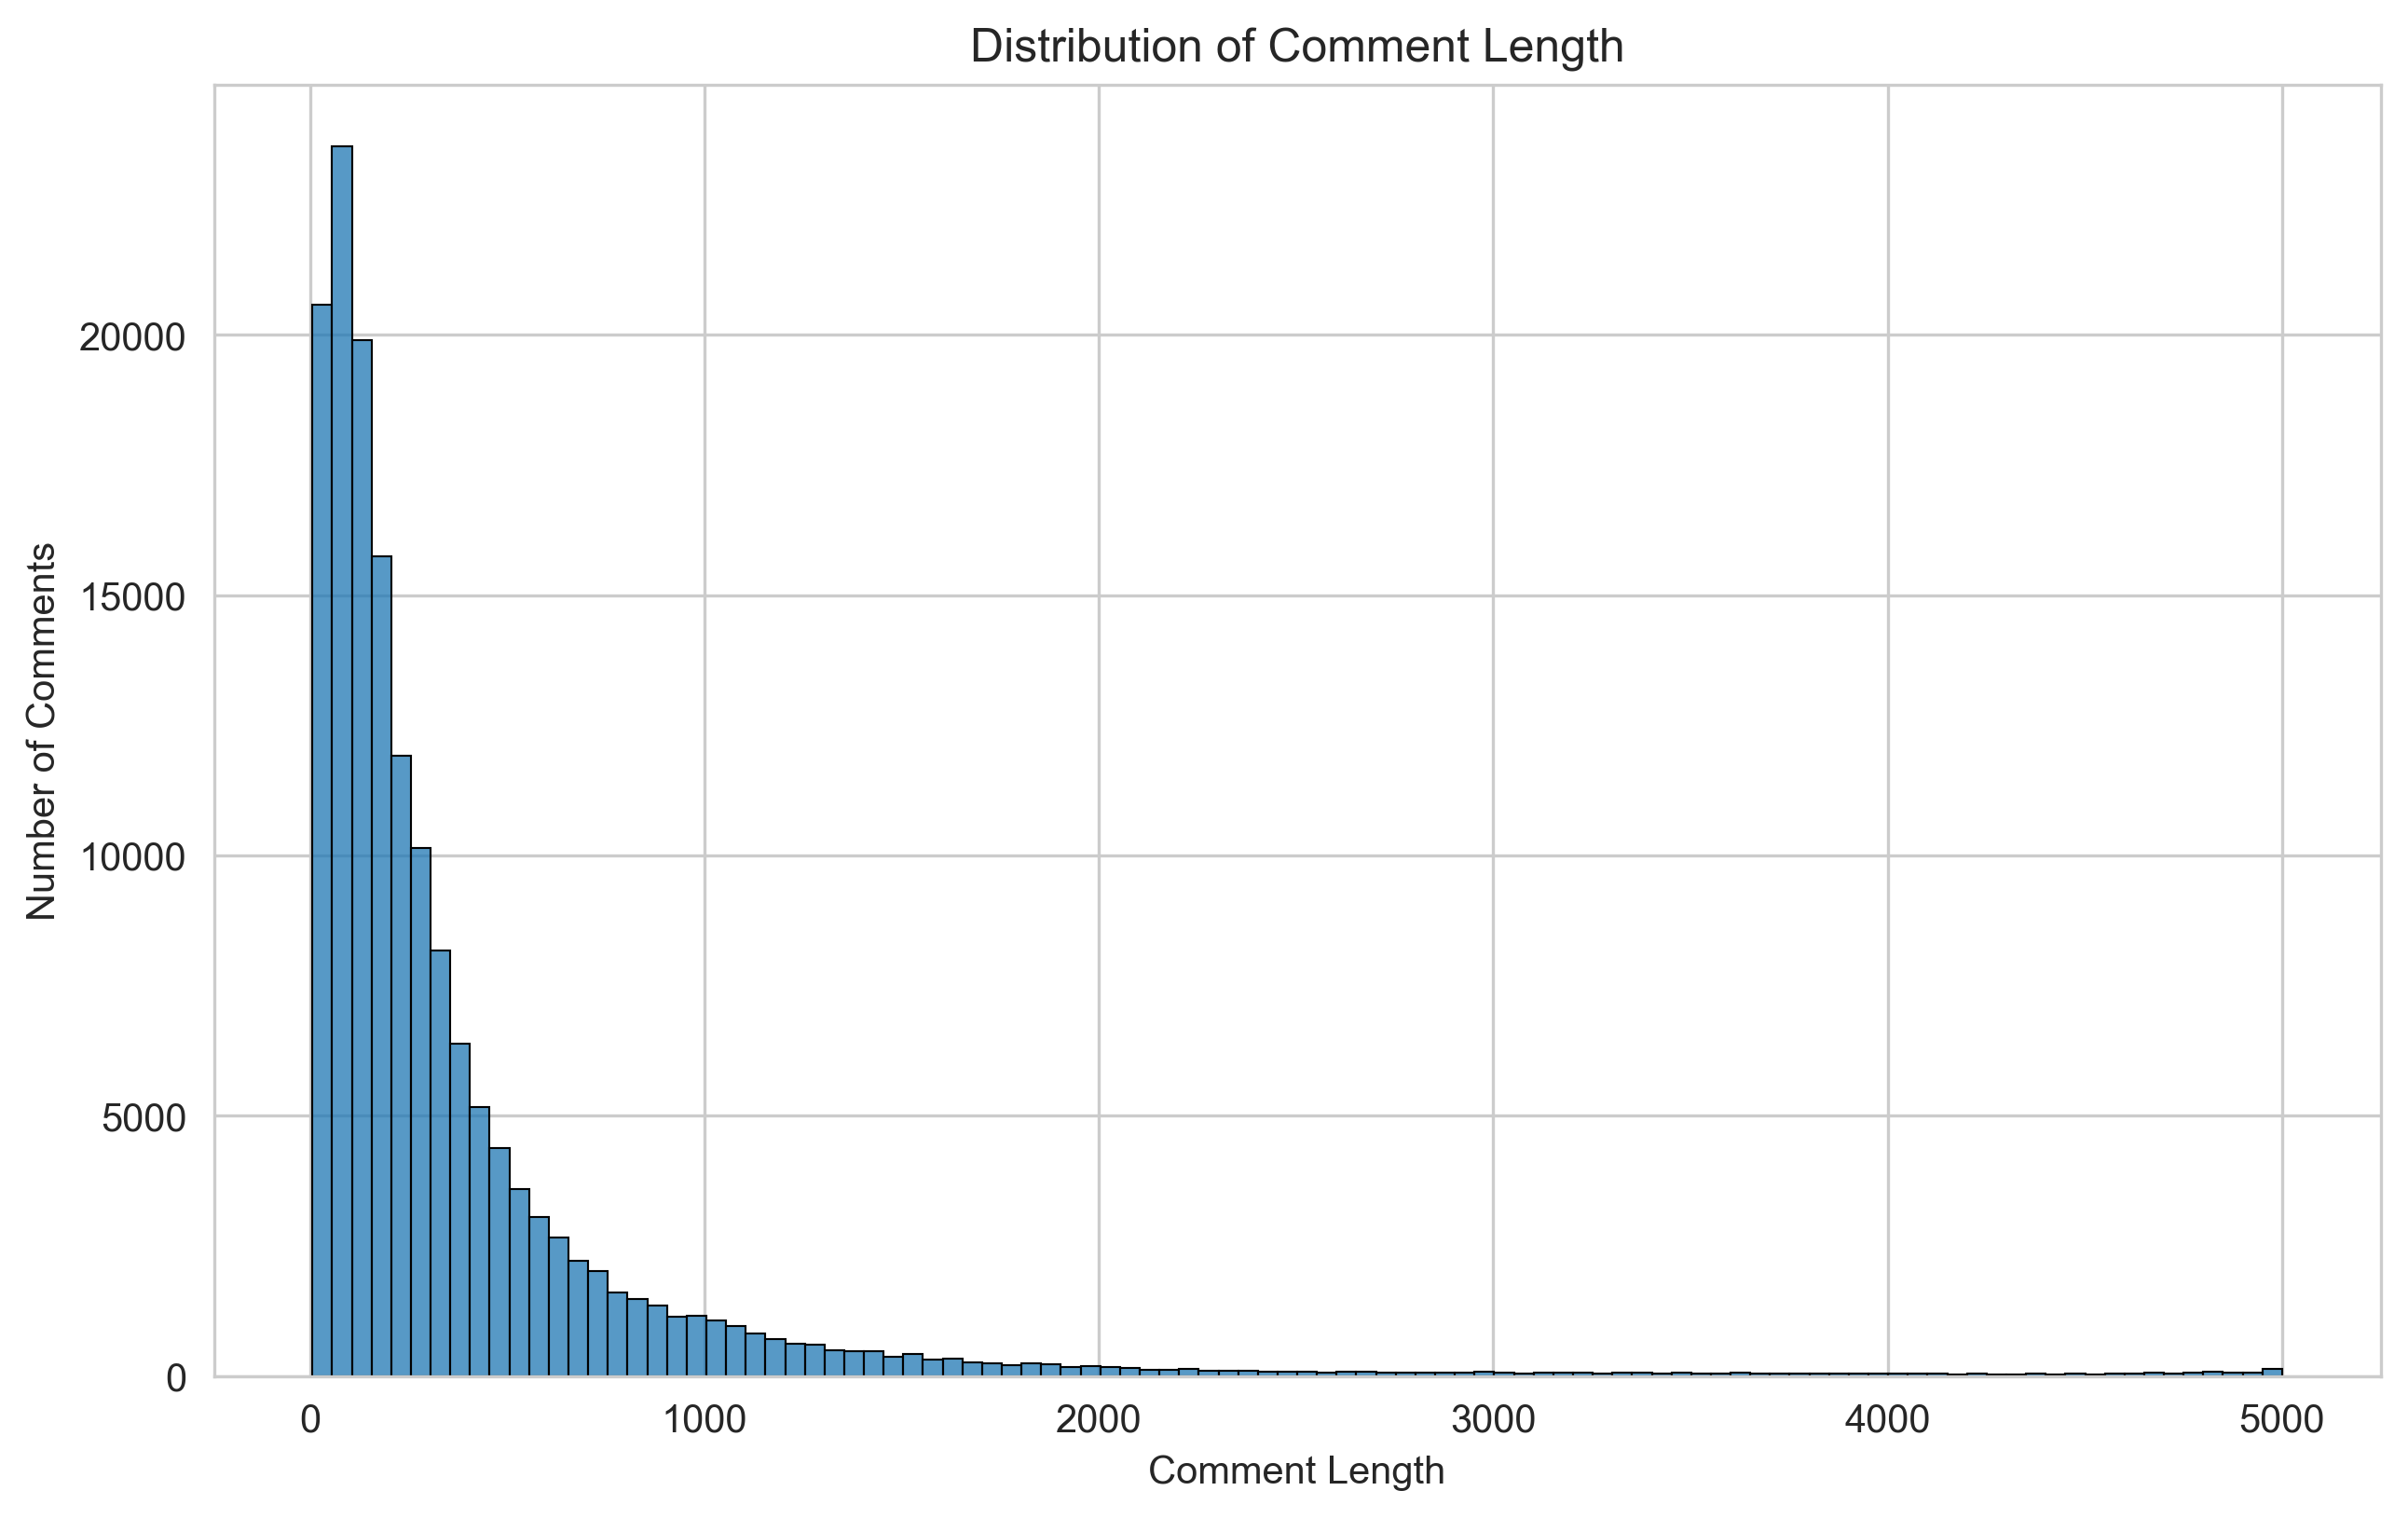

In [16]:
# plot the distribution of comment length
plt.figure(figsize=(10,6), dpi=300)
sns.histplot(data=train, x='comment_length', bins=100, edgecolor='black')
plt.title('Distribution of Comment Length')
plt.ylabel('Number of Comments')
plt.xlabel('Comment Length')
plt.show()

By analyzing the distribution of comment length, we can find that most comments have a length less than 500 characters. But there are also a few comments have very long length. Given the differences in the length of comments, we may need to remove extremely long comments to improve the performance of our model.

In [17]:
# drop the column "comment_length"
train.drop('comment_length', axis=1, inplace=True)
train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [18]:
# generate a wordcloud for a given data
def generate_wordcloud(data):
    text = " ".join(comment for comment in data.comment_text)
    wordcloud = WordCloud(stopwords=STOPWORDS, width=1000, height=600, background_color='white').generate(text)
    return wordcloud

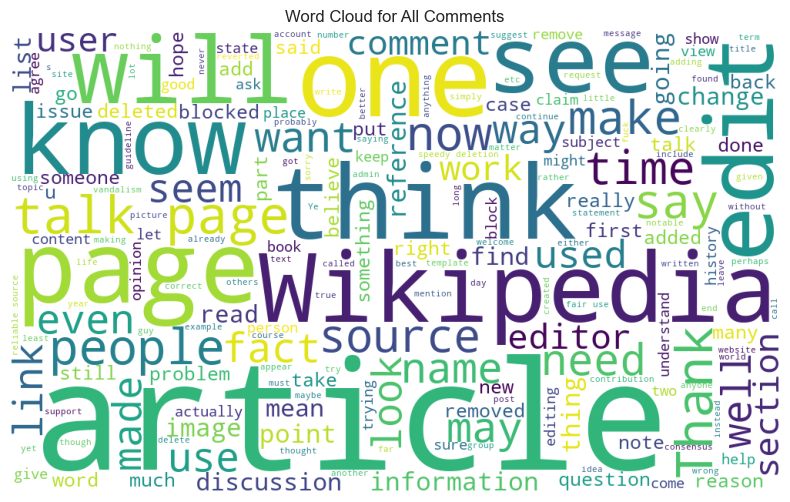

In [19]:
# generate a wordcloud for all comments
wordcloud = generate_wordcloud(train)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Word Cloud for All Comments')
plt.show()

The wordcloud shows the most common words in comments. Since the dataset from Wikipedia’s talk page and most of the comments are non-toxic, the most common words are Wikipedia, page, article, edit, etc.

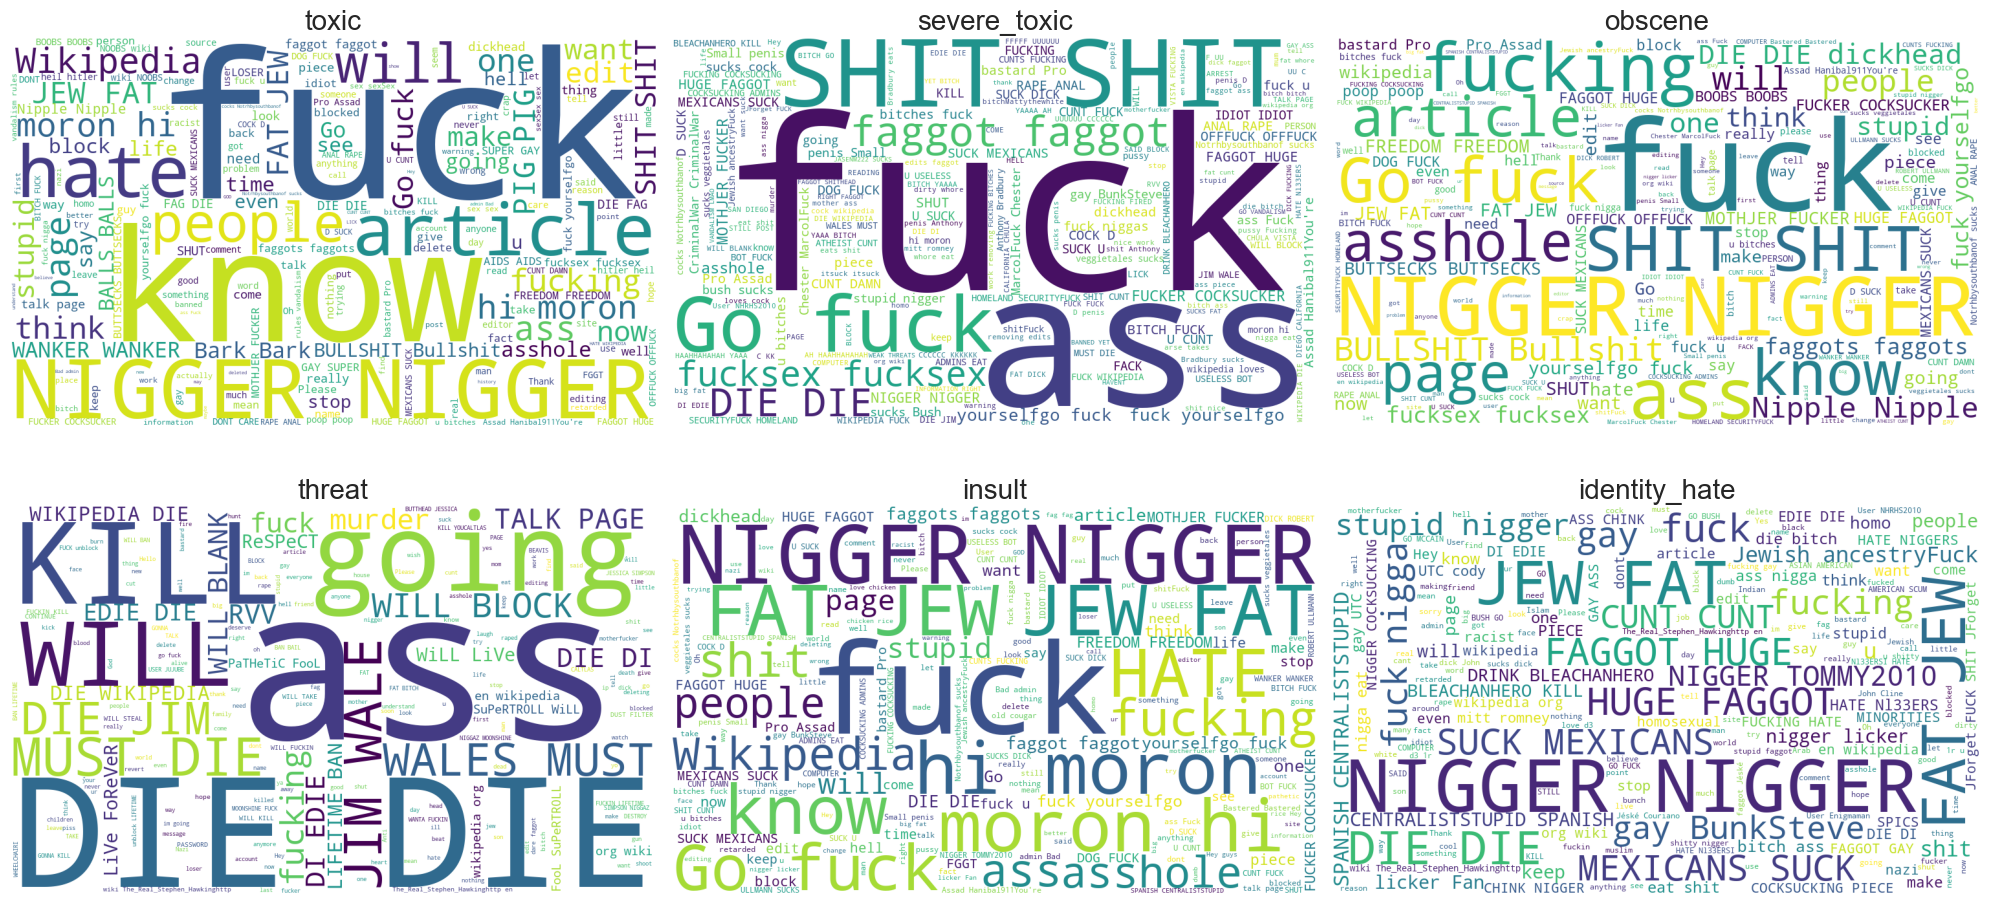

In [20]:
# generate wordclouds for each label in toxic comments
labels = train.columns[2:]
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for i, ax in enumerate(axes.flatten()):
    label = labels[i]
    subset = train[train[label] == 1]
    wordcloud = generate_wordcloud(subset)
    ax.imshow(wordcloud)
    ax.axis('off')
    ax.set_title(label, fontsize=20)
    
plt.tight_layout()
plt.show()

We generated the wordclouds for each toxic label, and we can see that toxic comments usually contain vulgar, profane, and offensive words compared to the non-toxic comments.

In [21]:
# preprocess the given text
def preprocess(text):
    text = text.lower() 
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)
    words = nopunct.split(' ')
    words = [word.encode('ascii', 'ignore').decode('ascii') for word in words]
    lmtzr = nltk.WordNetLemmatizer()
    words = [lmtzr.lemmatize(w) for w in words]
    words = [w for w in words if len(w) > 2]
    return words

In [22]:
# get several text samples in train dataset
sample_text = train['comment_text'].iloc[0:5]
sample_text

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object

In [23]:
# preprocess the text samples
for t in sample_text:
    print(preprocess(t))

['explanation', 'why', 'the', 'edits', 'made', 'under', 'username', 'hardcore', 'metallica', 'fan', 'were', 'reverted', 'they', 'weren', 'vandalism', 'just', 'closure', 'some', 'gas', 'after', 'voted', 'new', 'york', 'doll', 'fac', 'and', 'please', 'don', 'remove', 'the', 'template', 'from', 'the', 'talk', 'page', 'since', 'retired', 'now']
['aww', 'match', 'this', 'background', 'colour', 'seemingly', 'stuck', 'with', 'thanks', 'talk', 'january', 'utc']
['hey', 'man', 'really', 'not', 'trying', 'edit', 'war', 'just', 'that', 'this', 'guy', 'constantly', 'removing', 'relevant', 'information', 'and', 'talking', 'through', 'edits', 'instead', 'talk', 'page', 'seems', 'care', 'more', 'about', 'the', 'formatting', 'than', 'the', 'actual', 'info']
['more', 'can', 'make', 'any', 'real', 'suggestion', 'improvement', 'wondered', 'the', 'section', 'statistic', 'should', 'later', 'subsection', 'type', 'accident', 'think', 'the', 'reference', 'may', 'need', 'tidying', 'that', 'they', 'are', 'all',

After preprocessing, we can see that the punctuation and numbers are removed, the stopwords are removed, and the words are lemmatized. We get a list of words for each comment.

In [24]:
# use count vectorizer to vectorize the text samples
count_vectorizer = CountVectorizer(tokenizer=preprocess)
sample = count_vectorizer.fit_transform(sample_text)
sample.todense()

/Users/sage/Documents/Learn/IIT/CS584/Homework/project/CS584_Project_ToxicComment/env4ml/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


matrix([[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
         0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
         0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 3, 0, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
         0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
         0, 0,

This is the result of count vectorizer. This method calculates the frequency of each word in the document. Then it returns a vector of the frequency of each word. 

In [25]:
# use TF-IDF to vectorize the text samples
# tfidf_vectorizer = TfidfVectorizer(tokenizer=preprocess)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1), analyzer='word',
                         tokenizer=preprocess, stop_words='english',
                         strip_accents='unicode', use_idf=True, min_df=0.001) 
sample = tfidf_vectorizer.fit_transform(sample_text)
sample.todense()

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.21719196,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.21719196, 0.21719196, 0.        , 0.17522911, 0.        ,
         0.21719196, 0.21719196, 0.21719196, 0.        , 0.        ,
         0.        , 0.21719196, 0.        , 0.        , 0.        ,
         0.21719196, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.17522911, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.21719196, 0.        , 0.21719196, 0.        ,
         0.14545599, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.21719196, 0.        , 0.21719196,
         0.21719196, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.14545599, 0

We use TF-IDF to vectorize the text samples. In contrast to count vectorizer, TF-IDF also focus on the frequency of words in the whole document. The words that appear frequently in the whole document will have a lower weight. And the words that appear frequently in a specific document will have a higher weight. So TF-IDF can reduce the weight of common words and increase the weight of rare words. It is more suitable for our model.

In [26]:
# use TF-IDF to vectorize the train dataset
x_train = tfidf_vectorizer.fit_transform(train['comment_text'])
x_train

<159571x3192 sparse matrix of type '<class 'numpy.float64'>'
	with 2927306 stored elements in Compressed Sparse Row format>

In [27]:
# use TF-IDF to vectorize the test dataset
x_test = tfidf_vectorizer.transform(test['comment_text'])
x_test

<153164x3192 sparse matrix of type '<class 'numpy.float64'>'
	with 2439227 stored elements in Compressed Sparse Row format>

In [28]:
print(f"The qty of feature words is: {len(tfidf_vectorizer.get_feature_names_out())}")
tfidf_vectorizer.get_feature_names_out()[:20]

The qty of feature words is: 3192


array(['ability', 'able', 'absence', 'absolute', 'absolutely', 'absurd',
       'abuse', 'abused', 'abusing', 'abusive', 'academic', 'academy',
       'accept', 'acceptable', 'accepted', 'access', 'accident',
       'accordance', 'according', 'accordingly'], dtype=object)

Compare different models, especially those that perform well in text classification. Therefore, we chose the following basic models for comparison:
* Multinomial Naive Bayes (Multinomial Naive Bayes, MultinomialNB)
* Logistic Regression (LR)
* Linear Support Vector Machine (LinearSVC)

In [29]:
nb_model = MultinomialNB()
log_reg_model = LogisticRegression(max_iter=1000)
svc_model = LinearSVC(dual=False)

from sklearn.model_selection import cross_validate

def cross_validation_score(classifier, X_train, y_train):
    test_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    results = []

    name = classifier.__class__.__name__.split('.')[-1]

    for label in test_labels:
        scores = cross_validate(classifier, X_train, y_train[label], cv=10, 
                                scoring=['recall', 'f1', 'roc_auc'], n_jobs=-1)
        results.append([name, label, 
                        np.mean(scores['test_recall']), 
                        np.mean(scores['test_f1']), 
                        np.mean(scores['test_roc_auc'])])

    return results

# Example usage
methods1_cv = pd.DataFrame(cross_validation_score(nb_model, x_train, train))
methods2_cv = pd.DataFrame(cross_validation_score(log_reg_model, x_train, train))
methods3_cv = pd.DataFrame(cross_validation_score(svc_model, x_train, train))

methods_cv_df = pd.concat([methods1_cv, methods2_cv, methods3_cv]).reset_index(drop=True)
methods_cv_df.columns = ['Model', 'Label', 'Recall', 'F1', 'AUC']
methods_cv_df.round(3)


,Model,Label,Recall,F1,AUC
0,MultinomialNB,toxic,0.500,0.651,0.948
1,MultinomialNB,severe_toxic,0.236,0.334,0.977
2,MultinomialNB,obscene,0.547,0.683,0.962
3,MultinomialNB,threat,0.000,0.000,0.957
4,MultinomialNB,insult,0.462,0.590,0.959
5,MultinomialNB,identity_hate,0.093,0.162,0.960
6,LogisticRegression,toxic,0.607,0.724,0.957
7,LogisticRegression,severe_toxic,0.281,0.374,0.981
8,LogisticRegression,obscene,0.646,0.751,0.973
9,LogisticRegression,threat,0.134,0.218,0.979


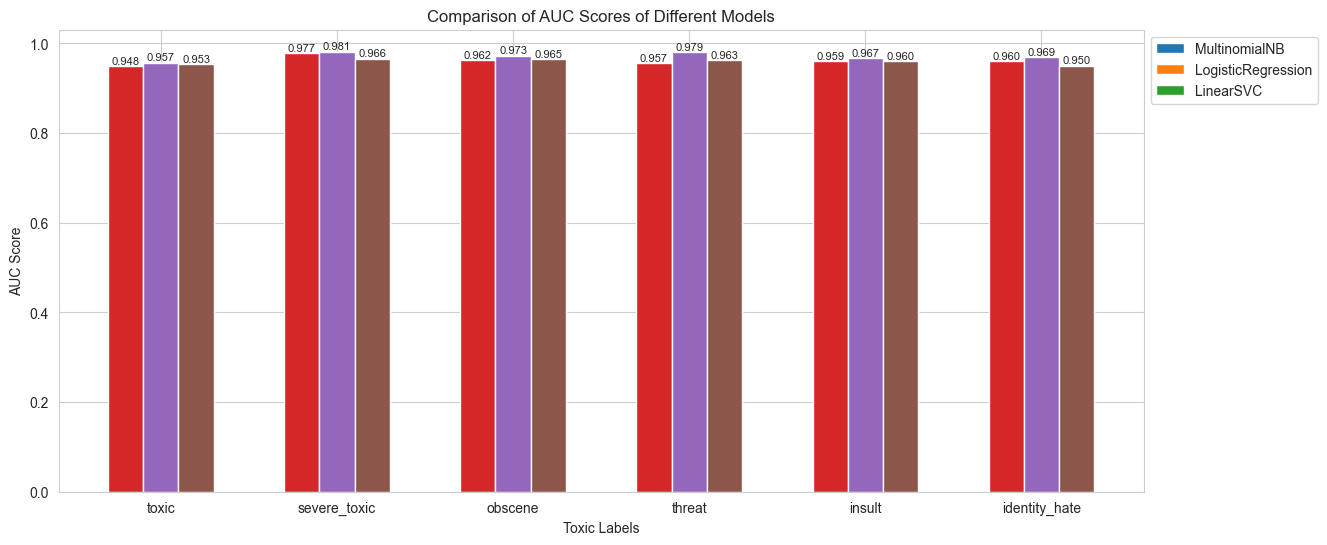

In [30]:
def plot_bar(df):
    plt.figure(figsize=(14, 6))

    # Extract unique labels and models
    labels = df['Label'].unique()
    models = df['Model'].unique()
    num_models = len(models)

    width_bar = 0.2
    x = np.arange(len(labels))  # label locations

    for i, model in enumerate(models):
        model_data = df[df['Model'] == model]
        plt.bar(x + i*width_bar, model_data['AUC'], width=width_bar, label=model)

    plt.xticks(x + width_bar*(num_models-1)/2, labels)

    for i in range(num_models):
        for k in plt.bar(x + i*width_bar, df['AUC'][i*len(labels):(i+1)*len(labels)], width=width_bar):
            height = k.get_height()
            plt.text(k.get_x() + k.get_width() / 2, height, f'{height:.3f}', fontsize=8, ha="center", va="bottom")

    plt.xlabel("Toxic Labels")
    plt.ylabel("AUC Score")
    plt.title("Comparison of AUC Scores of Different Models")
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

# Example usage
plot_bar(methods_cv_df)

- Based on the cross-validation above, we notice the LinearSVC and Logistic Regression models perform better. 
 
- Now we can check how these three models perform on real test datasets.

In [34]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, roc_auc_score


def score(classifier, X_train, y_train, X_test, y_test):
    methods = []
    name = classifier.__class__.__name__.split('.')[-1]
    test_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    for label in test_labels:
        classifier.fit(X_train, y_train[label])
        predicted = classifier.predict(X_test)
        valid_indices = y_test[label] != -1
        if np.any(valid_indices):
            recall = recall_score(y_test[valid_indices][label], predicted[valid_indices], average="weighted")
            f1 = f1_score(y_test[valid_indices][label], predicted[valid_indices], average="weighted")
            auc = roc_auc_score(y_test[valid_indices][label], predicted[valid_indices], average="weighted")
            conf_mat = confusion_matrix(y_test[valid_indices][label], predicted[valid_indices])
            methods.append([name, label, recall, f1, auc, conf_mat])
        else:
            methods.append([name, label, None, None, None, None])

    return methods

methods1 = pd.DataFrame(score(nb_model, x_train, train, x_test, test_labels))
methods2 = pd.DataFrame(score(log_reg_model, x_train, train, x_test, test_labels))
methods3 = pd.DataFrame(score(svc_model, x_train, train, x_test, test_labels))

methods_df = pd.concat([methods1, methods2, methods3]).reset_index(drop=True)
methods_df.columns = ['Model', 'Label', 'Recall', 'F1', 'AUC', 'ConfusionMatrix']
methods_df

,Model,Label,Recall,F1,AUC,ConfusionMatrix
0,MultinomialNB,toxic,0.935228,0.931681,0.763796,"[[56472, 1416], [2728, 3362]]"
1,MultinomialNB,severe_toxic,0.993545,0.993264,0.677083,"[[63434, 177], [236, 131]]"
2,MultinomialNB,obscene,0.964331,0.960832,0.755600,"[[59778, 509], [1773, 1918]]"
3,MultinomialNB,threat,0.996718,0.995095,0.502370,"[[63767, 0], [210, 1]]"
4,MultinomialNB,insult,0.960799,0.956428,0.717356,"[[59946, 605], [1903, 1524]]"
5,MultinomialNB,identity_hate,0.989731,0.986154,0.562926,"[[63231, 35], [622, 90]]"
6,LogisticRegression,toxic,0.931336,0.933285,0.831289,"[[55275, 2613], [1780, 4310]]"
7,LogisticRegression,severe_toxic,0.992482,0.992382,0.657585,"[[63380, 231], [250, 117]]"
8,LogisticRegression,obscene,0.965769,0.964607,0.811046,"[[59440, 847], [1343, 2348]]"
9,LogisticRegression,threat,0.995999,0.995532,0.601206,"[[63679, 88], [168, 43]]"


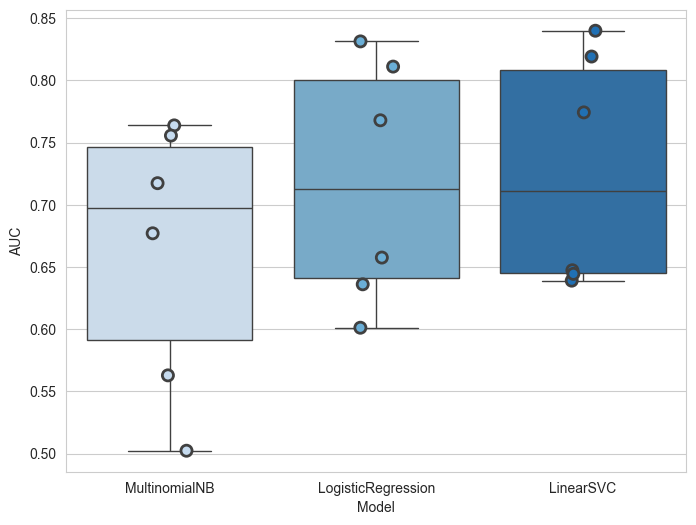

In [37]:
# show AUC scores of different models
plt.figure(figsize=(8, 6))

ax = sns.boxplot(x='Model', y='AUC', data=methods_df, palette="Blues", hue='Model')
sns.stripplot(x='Model', y='AUC', data=methods_df, size=8, jitter=True, 
              linewidth=2, palette="Blues", hue='Model')
plt.show()

In [38]:
methods_df[['AUC','Model']].groupby('Model', as_index=False).mean()

,Model,AUC
0,LinearSVC,0.727357
1,LogisticRegression,0.717519
2,MultinomialNB,0.663188


Based on the AUC scores, LinearSVC performs the best for this task, followed by Logistic Regression and then Multinomial Naive Bayes, which has the lowest performance.

---------- TOXIC Labeling ----------

----- MultinomialNB Model -----


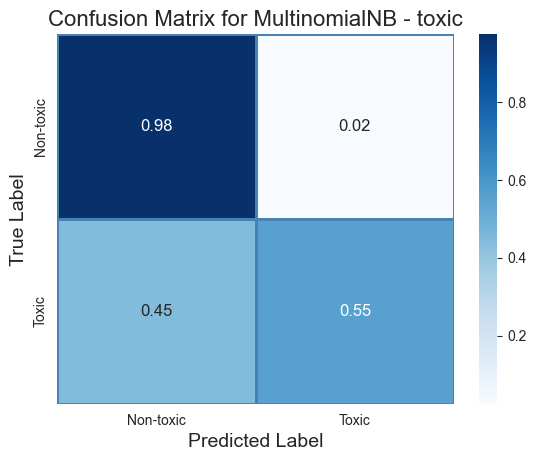


----- LogisticRegression Model -----


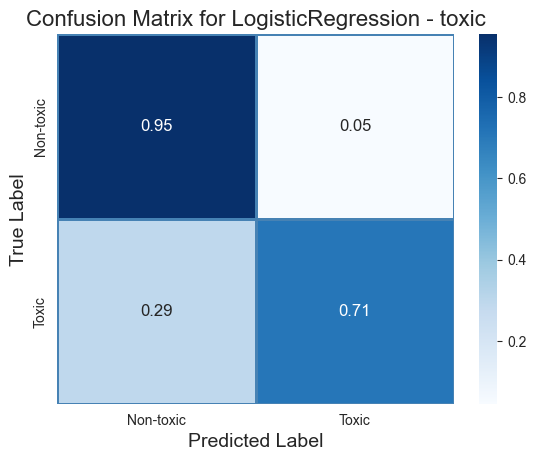


----- LinearSVC Model -----


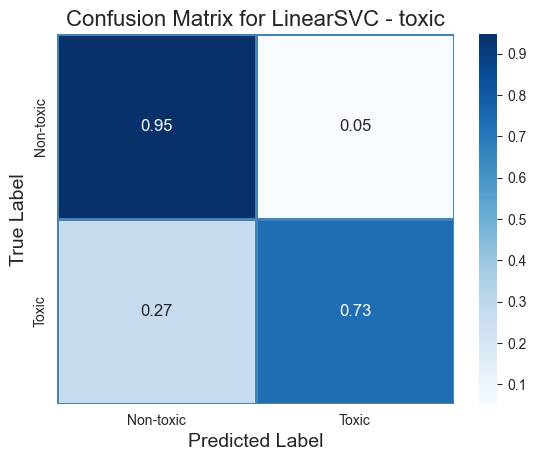

---------- SEVERE_TOXIC Labeling ----------

----- MultinomialNB Model -----


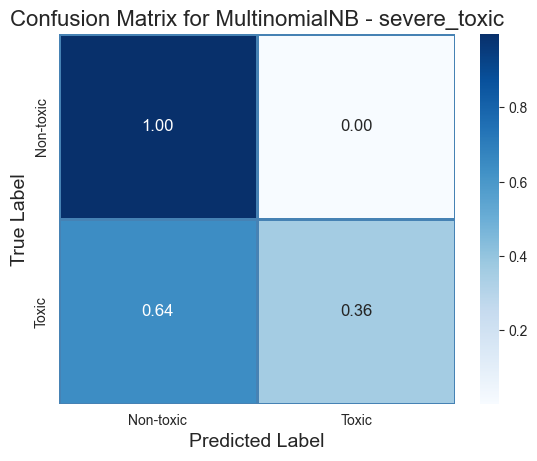


----- LogisticRegression Model -----


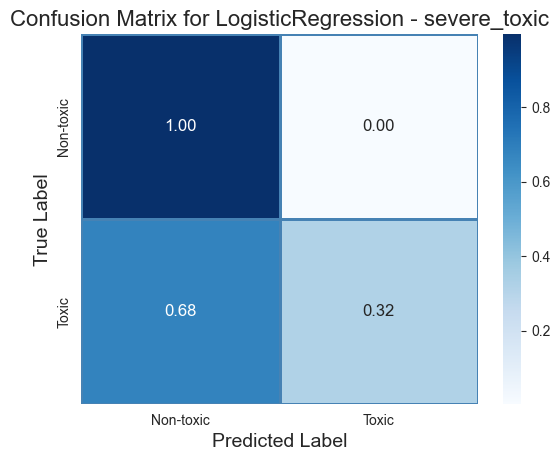


----- LinearSVC Model -----


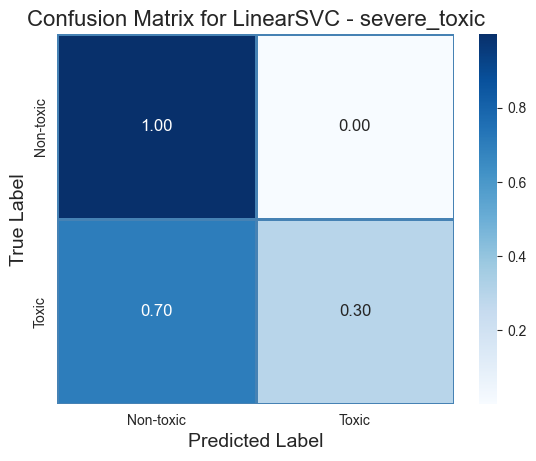

---------- OBSCENE Labeling ----------

----- MultinomialNB Model -----


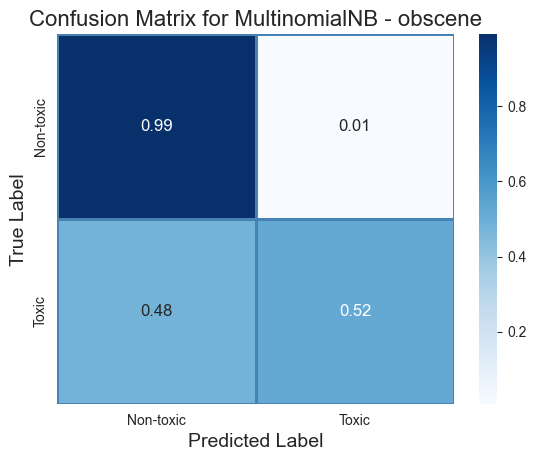


----- LogisticRegression Model -----


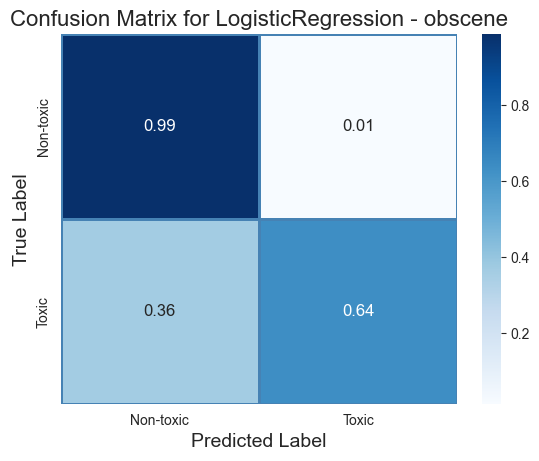


----- LinearSVC Model -----


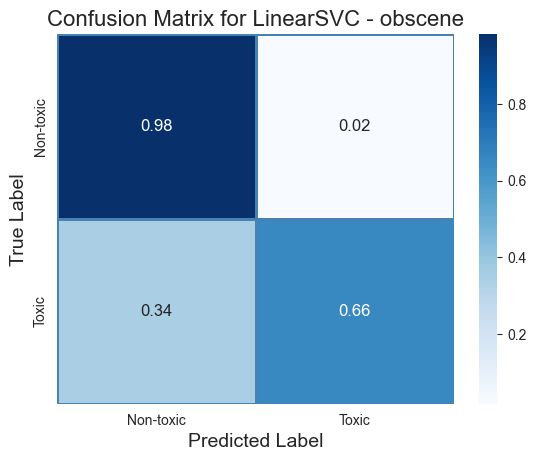

---------- THREAT Labeling ----------

----- MultinomialNB Model -----


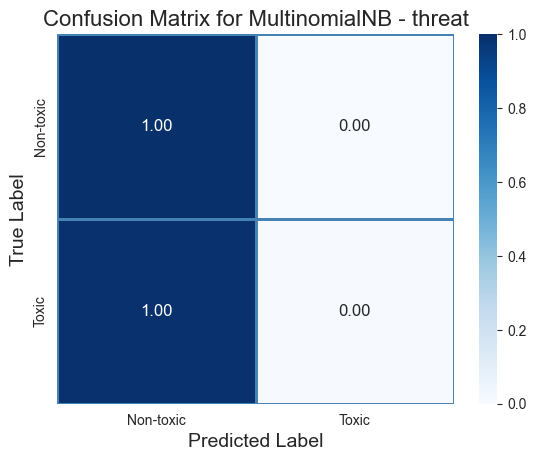


----- LogisticRegression Model -----


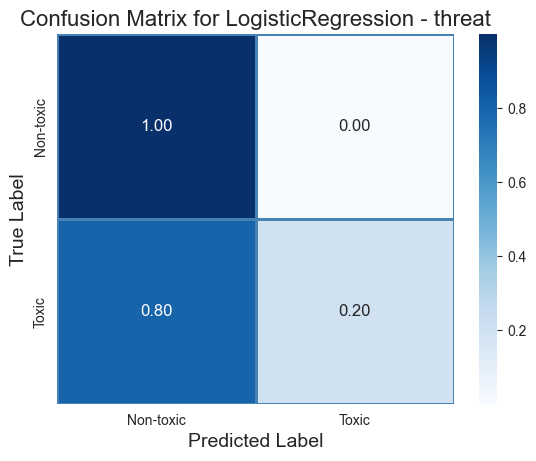


----- LinearSVC Model -----


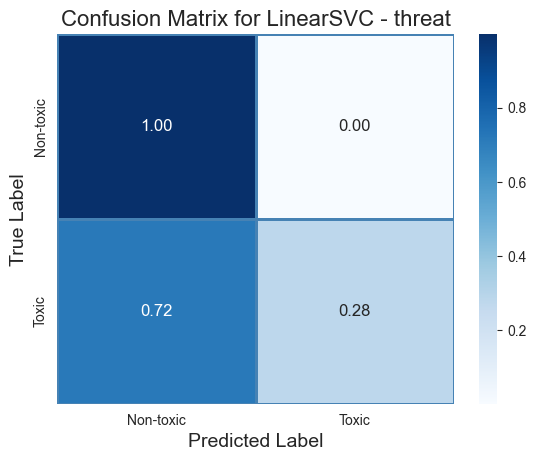

---------- INSULT Labeling ----------

----- MultinomialNB Model -----


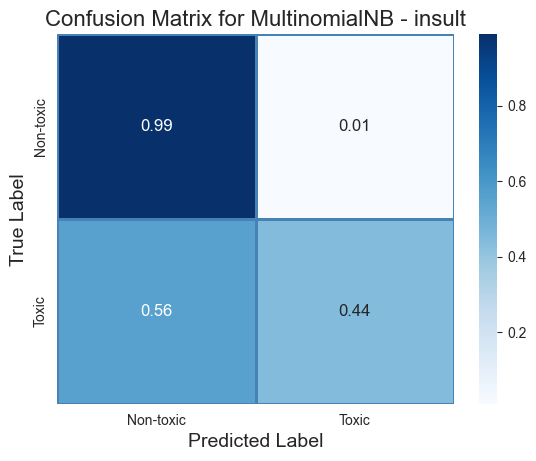


----- LogisticRegression Model -----


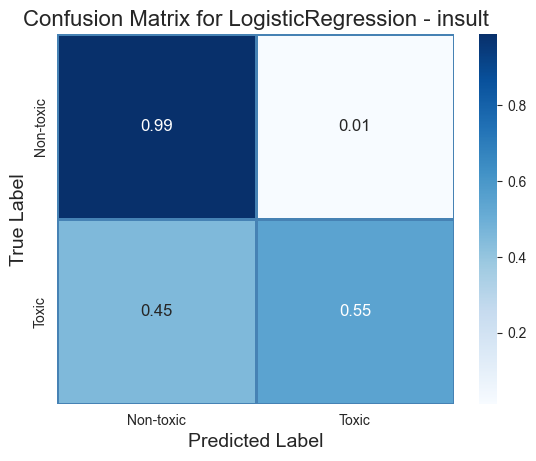


----- LinearSVC Model -----


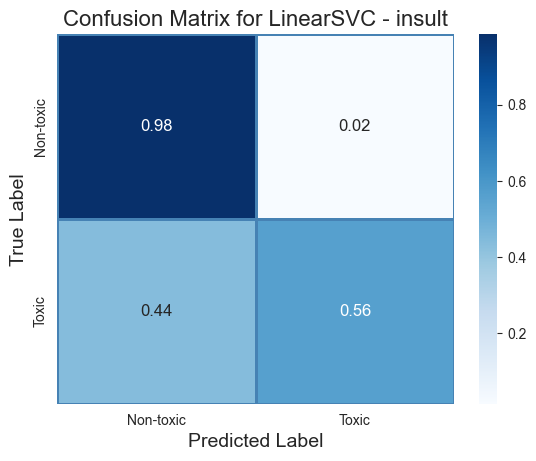

---------- IDENTITY_HATE Labeling ----------

----- MultinomialNB Model -----


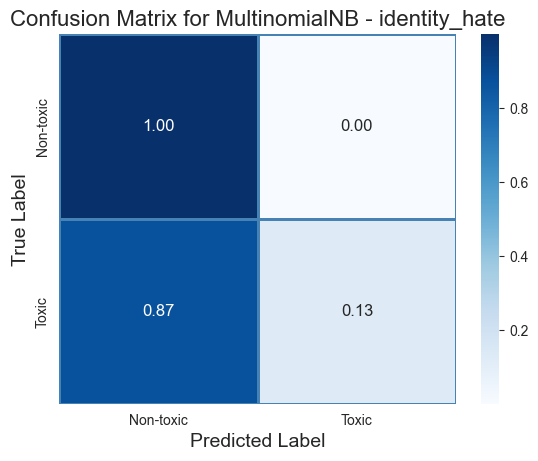


----- LogisticRegression Model -----


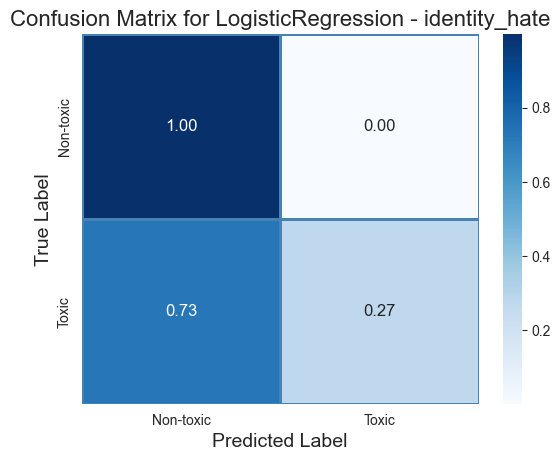


----- LinearSVC Model -----


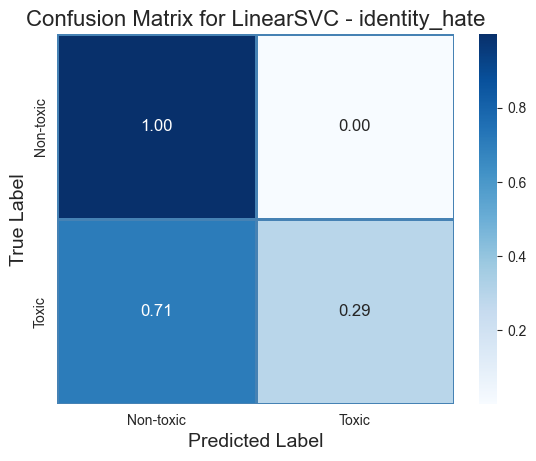

In [39]:
labels = {"toxic": 0, "severe_toxic": 1, "obscene": 2,
              "threat": 3, "insult": 4, "identity_hate": 5}
def drawConfusionMatrix(cm, model, label):
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ax = plt.axes()
    sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12}, cmap="Blues", 
                fmt='.2f', linewidths=2, linecolor='steelblue',
                xticklabels=("Non-toxic", "Toxic"), yticklabels=("Non-toxic", "Toxic"))
    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.title(f'Confusion Matrix for {model} - {label}', fontsize=16)
    plt.show()

def Matrix(label):
    print(f"---------- {label.upper()} Labeling ----------")
    pos = labels[label]
    for i in range(pos, len(methods_df), len(labels)):
        model = methods_df['Model'][i]
        cm = methods_df['ConfusionMatrix'][i]
        print(f"\n----- {model} Model -----")
        drawConfusionMatrix(cm, model, label)

for token in labels:
    Matrix(token)